### Daytum Course: Data Analytics, Geostatistics and Machine Learning Deep Dive

### Naive Bayes Demonstration and Exercise

#### Goal

Unconventional well production classification with naive Bayes.

#### Description

Here's a simple workflow, demonstration of naive Bayes classification for subsurface modeling workflows. This should help you get started with building subsurface models that with predictions based on multiple sources of information.

This method is great as it builds directly on our knowledge Bayesian statistics to provide a simple, but flexible classification method.

#### Bayesian Updating

The naive Bayes classifier is based on the conditional probability of a category, $k$, given $n$ features, $x_1, \dots , x_n$.  

\begin{equation}
p(C_k | x_1, \dots , x_n)
\end{equation}

we can solve this with Bayesian updating:

\begin{equation}
p(C_k | x_1, \dots , x_n) = \frac{p(x_1, \dots , x_n | C_k) p(C_k)}{p(x_1, \dots , x_n)}
\end{equation}

let's combine the likelihood and prior for the momment:

\begin{equation}
p(x_1, \dots , x_n | C_k) p(C_k) = p(x_1, \dots , x_n, C_k)
\end{equation}

we can exand the full joint distribution recursively as follows:

\begin{equation}
p(x_1, \dots , x_n, C_k)
\end{equation}

expansion of the joint with the conditional and prior

\begin{equation}
p(x_1 | x_2, \dots , x_n, C_k) p(x_2, \dots , x_n, C_k)
\end{equation}

continue recursively expanding

\begin{equation}
p(x_1 | x_2, \dots , x_n, C_k) p(x_2 | x_3, \dots , x_n, C_k) p(x_3, \dots , x_n, C_k)
\end{equation}

we can generalize as

\begin{equation}
p(x_1 | x_2, \dots , x_n, C_k) p(x_2 | x_3, \dots , x_n, C_k) p(x_3 | x_4, \dots , x_n, C_k) \ldots (x_{n-1} | x_n, C_k)  (x_{n} | C_k) p(C_k)
\end{equation}

#### Naive Bayes Approach

The likelihood, conditional probability with the joint conditional is difficult to calculate.  It requires information about the joint relationship between $x_1, \dots , x_n$ features. As $n$ increases this requires a lot of data to inform the joint distribution.

With the naive bayes approach we make the 'naive' assumption that the features are all **conditionally independent**.  This entails:

\begin{equation}
p(x_i | x_{i+1}, \ldots , x_n, C_k) = p(x_i | C_k)
\end{equation}

for all $i = 1, \ldots, n$ features.

We can now solve for the needed conditional probability as:

\begin{equation}
p(C_k | x_1, \dots , x_n) = \frac{p(C_k) \prod_{i=1}^{n} p(x_i | C_k)}{p(x_1, \dots , x_n)}
\end{equation}

We only need the prior, $p(C_k)$, and a set of conditionals, $p(x_i | C_k)$, for all predictor features, $i = 1,\ldots,n$ and all categories, $k = 1,\ldots,K$.

The evidence term, $p(x_1, \dots , x_n)$, is only based on the features $x_1, \dots , x_n$; therefore, is a constant over the categories $k = 1,\ldots,n$. 

* it ensures closure - probabilities over all categories sum to one 

* we simply standardize the numerators to sum to one over the categories.  

The naive Bayes approach is:

* simple to understand, builds on fundamental Bayesian statistics

* pratical even with small datasets since with the conditional independence we only need to estimate simple conditional distributions 

#### Import Required Packages  

We will need some standard packages.

In [1]:
import numpy as np                                          # ndarrys for gridded data
import pandas as pd                                         # DataFrames for tabular data
import os                                                   # set working directory, run executables
import matplotlib.pyplot as plt                             # for plotting
from scipy import stats                                     # summary statistics
import math                                                 # trig etc.
from sklearn.model_selection import train_test_split        # train and test split
from sklearn.naive_bayes import GaussianNB                  # naive Bayes model and prediction
from sklearn import metrics                                 # measures to check our models

#### Declare functions

Let's define a couple of functions to streamline plotting correlation matrices and visualization of a decision tree regression model. 

In [2]:
def plot_corr(dataframe,size=10):                               # plots a graphical correlation matrix 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
    
def visualize_model(model,xfeature,yfeature,response,title,):   # plots the data points and the prediction MAPS
    n_classes = 10
    cmap = plt.cm.plasma
    plot_step = 0.02
    plt.figure(figsize=(8,6))
    x_min, x_max = min(xfeature) - 1, max(xfeature) + 1
    y_min, y_max = min(yfeature) - 1, max(yfeature) + 1
    resp_min = round(min(response)); resp_max = round(max(response));
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    z_min = round(min(response)); z_max = round(max(response))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max)
    
    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=plt.cm.Greys, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation='vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    plt.subplots_adjust(left=0.0, bottom=0.0, right=0.6, top=0.8, wspace=0.2, hspace=0.2)
    plt.show()
    
def visualize_model_prob(model,xfeature,yfeature,response,title,):# plots the data points and the prediction probabilities 
    n_classes = 10
    cmap = plt.cm.plasma
    plot_step = 0.02
    plt.figure(figsize=(8,6))
    x_min, x_max = min(xfeature) - 1, max(xfeature) + 1
    y_min, y_max = min(yfeature) - 1, max(yfeature) + 1
    resp_min = round(min(response)); resp_max = round(max(response));
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    z_min = 0.0; z_max = 1.0
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z1 = Z[:,0].reshape(xx.shape); Z2 = Z[:,1].reshape(xx.shape)
    
    plt.subplot(121)
    cs1 = plt.contourf(xx, yy, Z1, cmap=cmap,vmin=z_min, vmax=z_max, levels=np.linspace(z_min, z_max, 100))
    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=plt.cm.Greys, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, edgecolors="black")
    plt.title(title + ' Probability of Low Production')
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(cs1, orientation = 'vertical')
    cbar.set_label('Probability', rotation=270, labelpad=20)
    
    plt.subplot(122)
    cs2 = plt.contourf(xx, yy, Z2, cmap=cmap,vmin=z_min, vmax=z_max, levels=np.linspace(z_min, z_max, 100))
    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=plt.cm.Greys, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, edgecolors="black")
    plt.title(title + ' Probability of High Production')
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(cs2, orientation = 'vertical')
    cbar.set_label('Probability', rotation=270, labelpad=20)
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
    plt.show()
    

#### Read the data table  

In [3]:
my_data = pd.read_csv('https://raw.githubusercontent.com/daytum/intake-data/refs/heads/master/daytum_cat/data/unconv_MV.csv')

Let's visualize the first several rows of our data stored in a DataFrame so we can make sure we successfully loaded the data file.

In [4]:
my_data.head(n=13)                                          # preview the first n rows of the DataFrame

,WellIndex,Por,LogPerm,AI,Brittle,TOC,VR,Production
0,1,15.91,1.67,3.06,14.05,1.36,1.85,177.381958
1,2,15.34,1.65,2.60,31.88,1.37,1.79,1479.767778
2,3,20.45,2.02,3.13,63.67,1.79,2.53,4421.221583
3,4,11.95,1.14,3.90,58.81,0.40,2.03,1488.317629
4,5,19.53,1.83,2.57,43.75,1.40,2.11,5261.094919
5,6,19.47,2.04,2.73,54.37,1.42,2.12,5497.005506
6,7,12.70,1.30,3.70,43.03,0.45,1.95,1784.266285
7,8,14.15,1.23,2.53,39.43,0.79,1.54,1943.639213
8,9,16.18,1.34,3.45,45.79,0.56,1.95,3176.523611
9,10,20.51,2.48,2.78,28.99,1.78,2.24,2522.792318


Let's remove the well index and check the summary summary statistics.

In [5]:
my_data = my_data.iloc[:,1:]                                # remove the well index
my_data.describe().transpose()                              # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.719480,15.077006,-10.500000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.003810,0.504978,-0.260000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


It is good that we checked the summary statistics, because we have some negative values for brittleness and total organic carbon. The is physically imposible.  The values must be in error. We know the lowest possible values are 0.0, so we will truncate on 0.0.  We use the *get_numerical_data()* DataFrame member function to get a shallow copy of the data from the DataFrame.  Since it is a shallow copy, any changes we make to the copy are made to the data in the original DataFrame.  This allows us to apply this simple conditional statement to all the data values in the DataFrame all at once.

Let's also make a categorical variable for production, based on a threshold of 4,000 MCFPD.

* high production > 4,000 MCFPD, cprod = 1
* low production <= 4,000 MCFPD, cprod = 0

In [6]:
num = my_data._get_numeric_data()                           # get shallow copy of the numerical values from the DataFrame
num[num < 0] = 0                                            # truncate negative values to 0.0
my_data['cProd'] = np.where(my_data['Production']>=4000, 1, 0)    # conditional statement assign a new feature
my_data.describe().transpose()                              # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.731480,15.033593,0.000000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.006170,0.499838,0.000000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413
cProd,1000.0,0.116000,0.320385,0.000000,0.00000,0.00000,0.000000,1.00000


Let's make sure that we have the new categorical feature for production.

In [7]:
my_data.head()                                              # preview the first n rows of the updated DataFrame

,Por,LogPerm,AI,Brittle,TOC,VR,Production,cProd
0,15.91,1.67,3.06,14.05,1.36,1.85,177.381958,0
1,15.34,1.65,2.60,31.88,1.37,1.79,1479.767778,0
2,20.45,2.02,3.13,63.67,1.79,2.53,4421.221583,1
3,11.95,1.14,3.90,58.81,0.40,2.03,1488.317629,0
4,19.53,1.83,2.57,43.75,1.40,2.11,5261.094919,1


This dataset has variables from 200 unconventional wells including well average porosity, log transform of permeability (to linearize the relationships with other variables), accoustic impedance (kg/m2s*10^6), brittness ratio (%), total organic carbon (%), vitrinite reflectance (%), and initial production 90 day average (MCFPD).  Note, the dataset is synthetic.

#### Calculate the correlation matrix 

For multivariate analysis it is a good idea to check the correlation matrix.  We can calculate it and view it in the console with these commands.

In [8]:
corr_matrix = np.corrcoef(my_data.iloc[:,:7], rowvar = False)  # correlation matrix without the categorical value
print(np.around(corr_matrix,2))                           # print the correlation matrix to 2 decimals

[[ 1.    0.81 -0.51 -0.25  0.71  0.08  0.69]
 [ 0.81  1.   -0.32 -0.15  0.51  0.05  0.57]
 [-0.51 -0.32  1.    0.17 -0.55  0.49 -0.33]
 [-0.25 -0.15  0.17  1.   -0.24  0.3  -0.07]
 [ 0.71  0.51 -0.55 -0.24  1.    0.31  0.5 ]
 [ 0.08  0.05  0.49  0.3   0.31  1.    0.14]
 [ 0.69  0.57 -0.33 -0.07  0.5   0.14  1.  ]]


Note the 1.0 diagonal resulting from the correlation of each variable with themselves.  

Let's use our function declared above to make a graphical correlation matrix visualization.  This may inprove our ability to spot features.  It relies on the built in correlation matrix method with Numpy DataFrames and MatPlotLib for plotting.

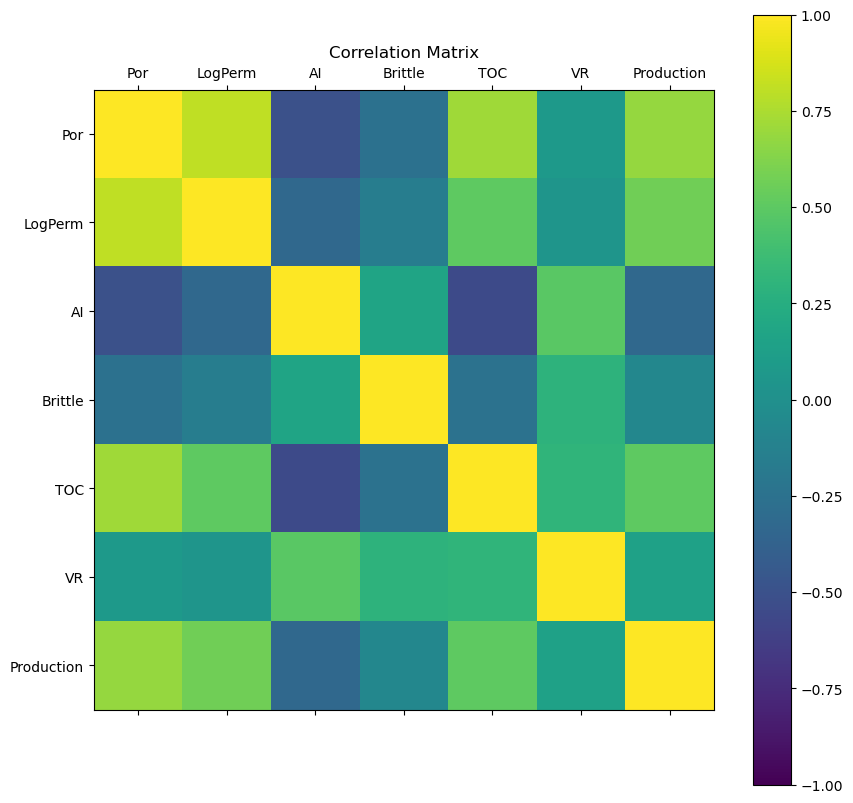

In [9]:
plot_corr(my_data.iloc[:,:7],10)                            # using our correlation matrix visualization function
plt.show()

#### Working with Only Two Features

Let's simplify the problem to 2 feature), Porosity and Brittleness to predict Production rate.  By working with only 2 features, it is very easy to visualize the segmentation of the feature space (it is only 2D and can be shown compleltely on a single plot).

In [10]:
my_data_subset = my_data.iloc[:,[0,3,7]]                # extract just por, brittle and prod with 100 samples
X_train, X_test, y_train, y_test = train_test_split(my_data_subset.iloc[:,[0,1]], my_data_subset.iloc[:,2], test_size=0.25, random_state=73073)
y_train = pd.DataFrame({'cprod':y_train.values})
y_test = pd.DataFrame({'cprod':y_test.values})

Let's first check the univariate statistics of Porosity, Brittleness and Producton.

In [11]:
X_train.describe().transpose()                         # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,750.0,14.979960,3.036168,5.4,12.8525,15.005,17.1125,24.65
Brittle,750.0,50.288707,14.961855,0.0,40.4625,50.470,59.7675,93.47


In [12]:
X_test.describe().transpose()                         # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,250.0,14.86196,3.014273,5.79,12.8825,14.965,16.920,21.89
Brittle,250.0,48.05980,15.154151,3.03,37.4475,47.505,57.195,89.85


In [13]:
y_train.describe()[:2]                                    # calculate summary statistics for the data

,cprod
count,750.000000
mean,0.117333


In [14]:
y_test.describe()[:2]                                    # calculate summary statistics for the data

,cprod
count,250.000
mean,0.112


Let's first check the univariate distributions of Porosity, Brittleness and Producton.

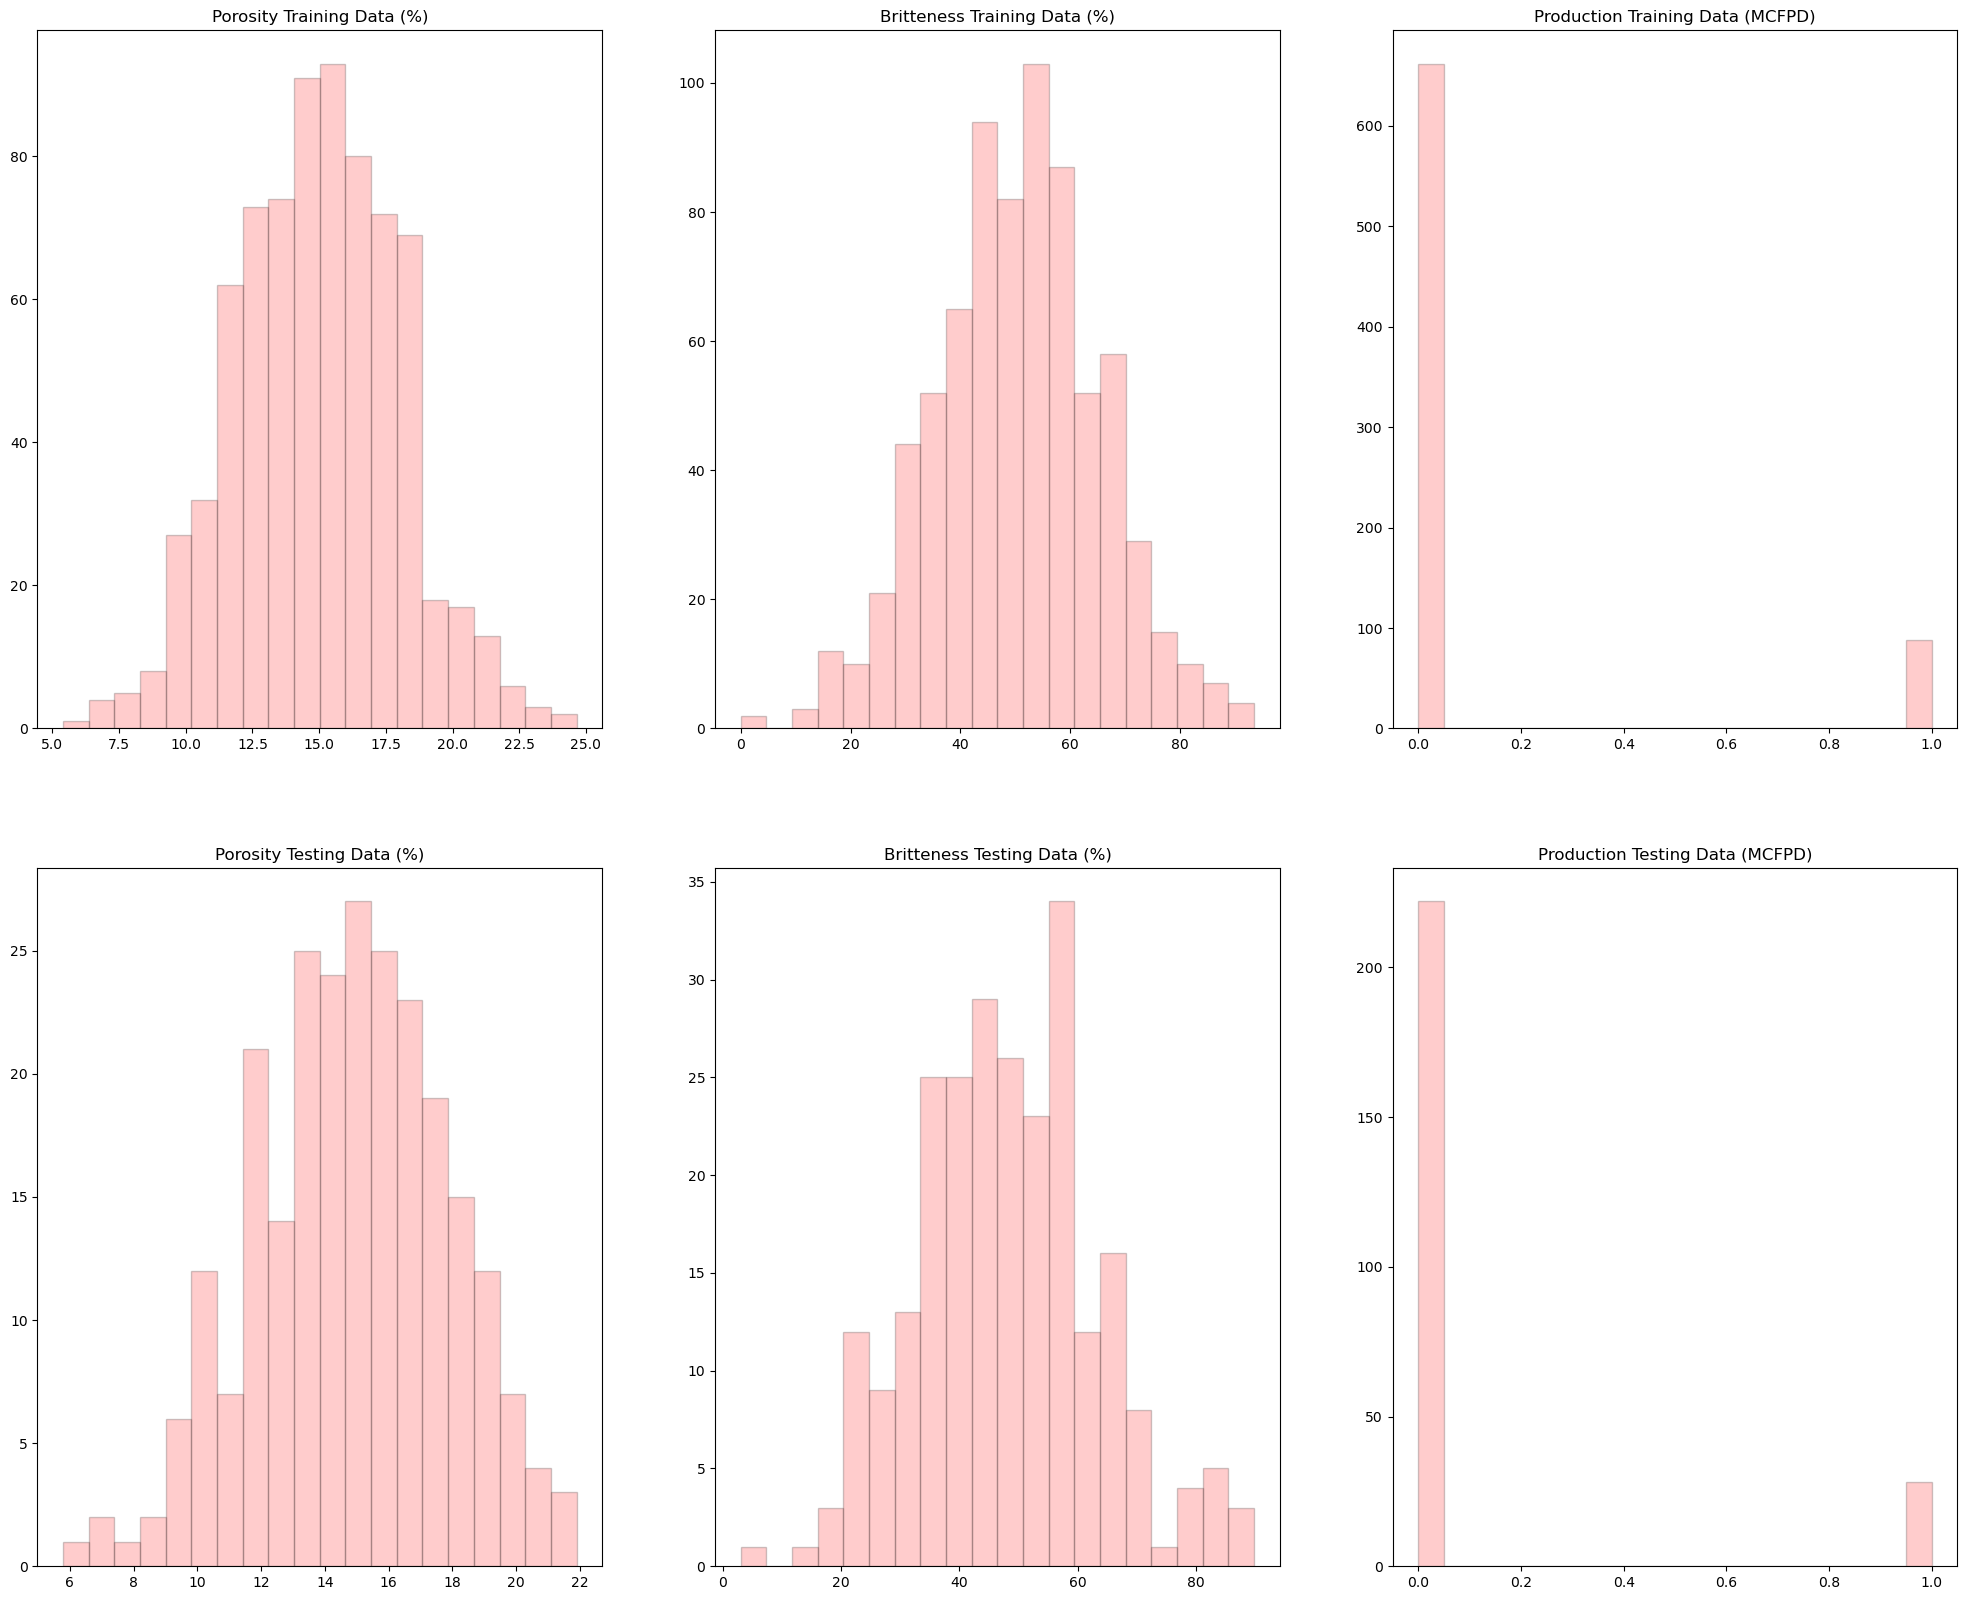

In [15]:
plt.subplot(231)
plt.hist(X_train["Por"], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Porosity Training Data (%)')

plt.subplot(232)
plt.hist(X_train["Brittle"], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Britteness Training Data (%)')

plt.subplot(233)
plt.hist(y_train['cprod'], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Production Training Data (MCFPD)')

plt.subplot(234)
plt.hist(X_test["Por"], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Porosity Testing Data (%)')

plt.subplot(235)
plt.hist(X_test["Brittle"], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Britteness Testing Data (%)')

plt.subplot(236)
plt.hist(y_test['cprod'], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Production Testing Data (MCFPD)')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.2, wspace=0.2, hspace=0.2)
plt.show()

The distributions are well behaved, we cannot observe obvious gaps nor truncations.  Let's look at a scatter plot of Porosity vs. Brittleness with points colored by Production.

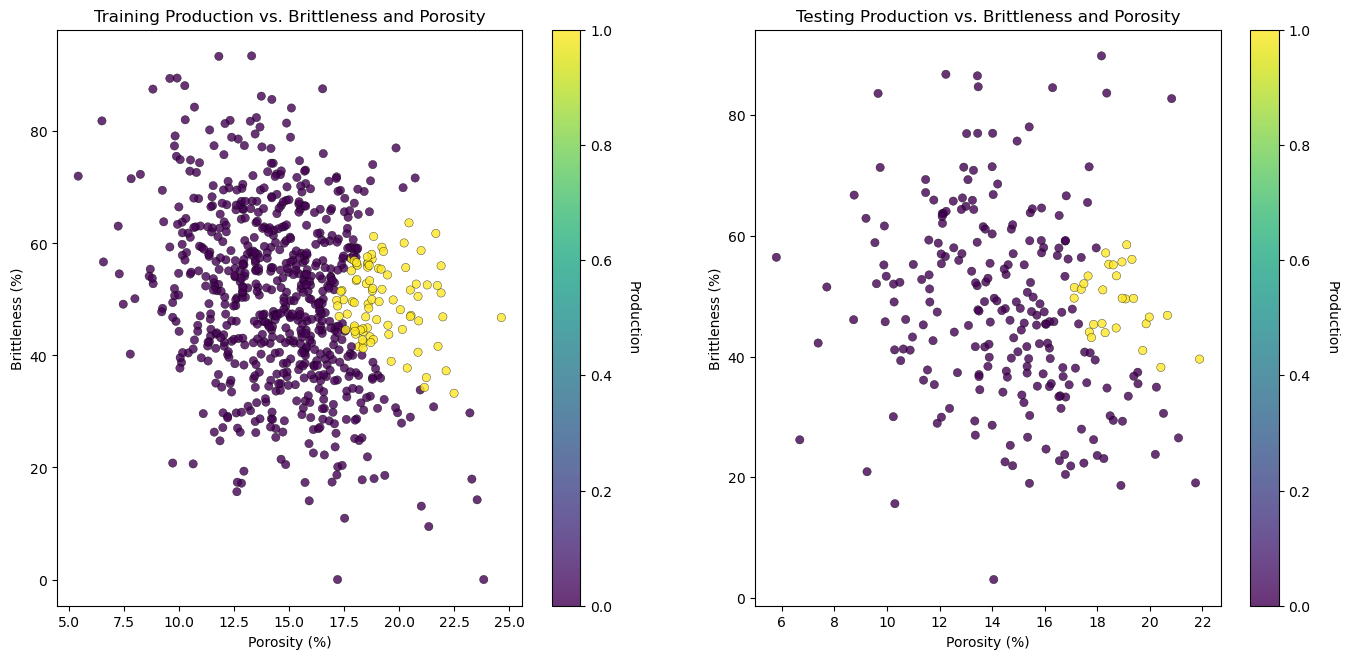

In [16]:
plt.subplot(121)
im = plt.scatter(X_train["Por"],X_train["Brittle"],s=None, c=y_train['cprod'], marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3,  edgecolors="black")
plt.title('Training Production vs. Brittleness and Porosity'); plt.xlabel('Porosity (%)'); plt.ylabel('Brittleness (%)')
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Production", rotation=270, labelpad=20)

plt.subplot(122)
im = plt.scatter(X_test["Por"],X_test["Brittle"],s=None, c=y_test['cprod'], marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3,  edgecolors="black")
plt.title('Testing Production vs. Brittleness and Porosity'); plt.xlabel('Porosity (%)'); plt.ylabel('Brittleness (%)')
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Production", rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)

plt.show()

#### Instantiate, Fit and Predict with Gausian Naive Bayes

Let's build a Gaussian naive Bayes model.

We select the Gaussian model as it simplifies the inference problem to just a set of conditional means and variances given each feature.

Recall we can set a prior probability of each response category

* We will use the proportions from the training dataset.

* 0.43 for high production (the mean of the binary dataset is the proportion of 1's)

* 0.57 for low production (1 - proportion of high production)

Another option would be to assume a naive, uniform prior, substitute the following:

```python
priors = (0.5,0.5)   # naive prior
```

In [17]:
priors = (0.57,0.43)                                        # set the prior probabilities of low and high production

Let's build our Gaussian naive Bayes model.

* instantiate it with the priors 

* train with the training data, we use the standard fit function 

In [18]:
gnb = GaussianNB(priors = priors)                           # instantiate the Gaussian naive Bayes model
GaussianNB_fit = gnb.fit(X_train,y_train['cprod'].values)   # train with the training data

Let's predict with our new model over the testing dataset.

* test by predicting with the testing data, we use the standard prediction function 

In [19]:
y_pred = GaussianNB_fit.predict(np.c_[X_test['Por'].values,X_test['Brittle'].values]) # predict over the testing data

/opt/conda/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


#### Model Checking

Let's check our model. With scikit learn we have great built in tools to evaluate our classification model. Let's try the classification report first.

```python
classification_report(truth, predicted)                # build a classification report to check our classification model
```

We get a table with summary metrics for model performance.

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test['cprod'].values, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       222
           1       0.67      1.00      0.80        28

    accuracy                           0.94       250
   macro avg       0.83      0.97      0.88       250
weighted avg       0.96      0.94      0.95       250



The metrics include:
    
    * recall - the ratio of true positives divided by all cases of the category in the testing dataset
    
    * precision - the ratio of true positives divided by all positives (true positives + false positives)
    
    * f1-score - the harmonic mean of recall and precision
    
    * support - the number of samples of each category in the testing data
    
I also like to look at the confusion matrix.  

* the x axis is the prediction - category 0 or 1

* the y axis is the truth - category 0 or 1

In [21]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test['cprod'].values, y_pred))

[[208  14]
 [  0  28]]


From above we can observe:

* 26 low production wells classified correctly as low production

* 1 high production well misclassified as low production

* 2 low production wells misclassified as high production

* 21 high production wells classified correctly as high production

#### Visualizing the Classification Model

Let's visualize the model over the entire feature space.

* here's the training data with the classification over the full range of predictor features.

* blue for low production and yellow for high production

Note: naive Bayes provides the posterior probability of high and low production

* the classifications below are based on maximum apriori selection (MAPS), selecting the category with the highest probability

Let's visualize the classification model (blue - low production, yellow - high production) over the predictor feature space with the training data plotted (white - low production, black - high production).

/opt/conda/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


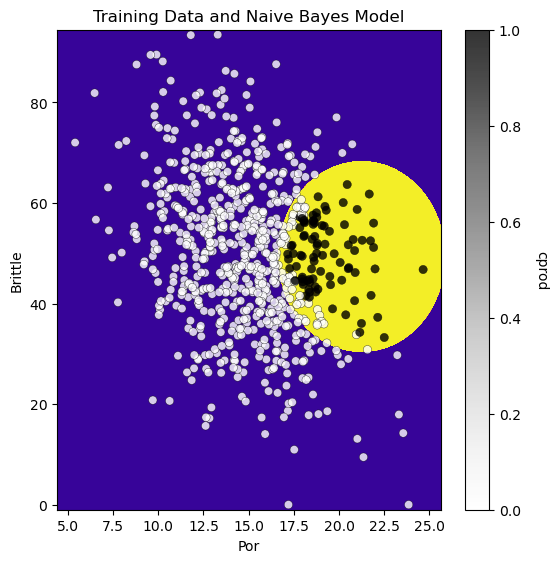

In [22]:
visualize_model(GaussianNB_fit,X_train["Por"],X_train["Brittle"],y_train['cprod'],'Training Data and Naive Bayes Model')

We could also visualize the posterior probabilities of low and high production.

* here's the posterior probability of low and high production over the predictor feature space

/opt/conda/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


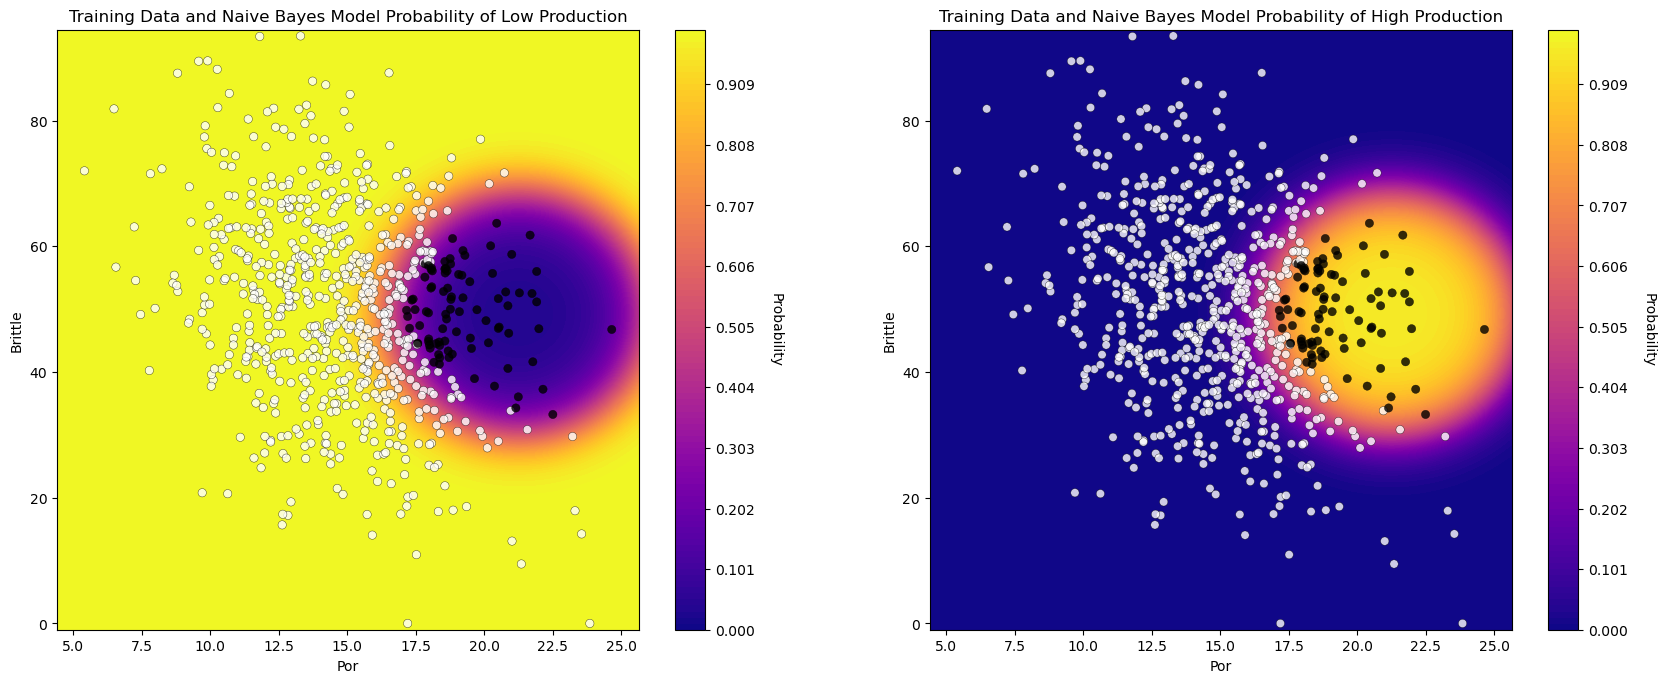

In [23]:
visualize_model_prob(GaussianNB_fit,X_train["Por"],X_train["Brittle"],y_train['cprod'],'Training Data and Naive Bayes Model')

Finally, let's look at the classification model over the predictor feature space (blue - low production, yellow - high production) with the testing data plotted (white - low production, black - high production).

/opt/conda/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


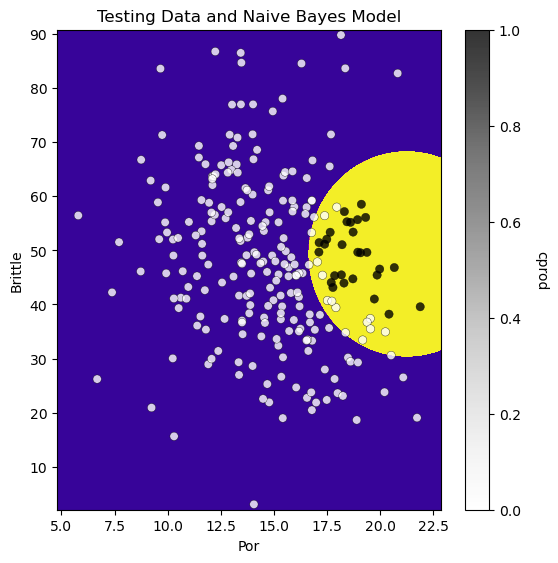

In [24]:
visualize_model(GaussianNB_fit,X_test["Por"],X_test["Brittle"],y_test['cprod'],'Testing Data and Naive Bayes Model')

We have a reasonable model to predict well production from porosity and brittleness for an unconventional reservoir.

#### Comments

This was a basic demonstration of naive Bayes for prediction. A lot more could be done, for example, we could have applied variants such as:

* multinomial naive Bayes

* compliment naive Bayes

* Bernoulli naive Bayes

This was a basic demonstration of Naive Bayes. We could have worked with more predictor features, but for learning the method, it is nice to be able to visualize the entire classification in one plot! 

<i>&copy; Copyright daytum 2025. All Rights Reserved</i>